## Initialization

In [37]:
#from Classes import Data, Assignment
    # Later, we can move the Class definitions into a separate file

In [1]:
%pip install pulp

# Install Gurobi
%pip install gurobipy 
    # Obtain academic license from: https://www.gurobi.com/downloads/end-user-license-agreement-academic/

# Install SCIP
%pip install pyscipopt

# Other useful packages
import numpy as np
import pandas as pd
import copy # To make deep copies
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Check with solvers available on computer
import pulp as pl
solver_list = pl.listSolvers(onlyAvailable=True)
print(solver_list)

['GUROBI', 'GUROBI_CMD', 'PULP_CBC_CMD', 'SCIP_CMD', 'FSCIP_CMD', 'SCIP_PY']


## Define classes
Define the following classes:
* 'Data': contains
    * Number of students
    * Number of schools
    * Preferences students
    * Preferences schools
    * Capacities schools
    * Names of students
    * Names of schools
    * File name
* 'Assignment': the selection probabilities of the students to the schools

In [6]:
class Data:
    # Define the initialization of an object from this class
    def __init__(self, n_stud: int, n_schools: int, pref: list, prior: list, cap:list, ID_stud:list, ID_school:list, file_name:str):
        self.n_stud = n_stud
        self.n_schools = n_schools
        self.pref = copy.deepcopy(pref)
        self.prior = copy.deepcopy(prior)
        self.cap = copy.deepcopy(cap)
        self.ID_stud = copy.deepcopy(ID_stud)
        self.ID_school = copy.deepcopy(ID_school)
        self.file_name = file_name

        

    # Choose what is being shown for the command 'print(MyData)', where 'MyData' is an instance of the class 'Data'
    def __str__(self):
        s ="The data instance has the following properties: \n"
        s += f"\n\t{self.n_stud} students.\n\t{self.n_schools} schools. \n\n \tPREFERENCES:\n"
        for i in range(0,self.n_stud):
            s+= f"\t{self.ID_stud[i]}\t"
            for j in range(0, len(self.pref[i])):
                if len(self.pref[i][j]) >= 2:
                    s+=f"{{"
                    for k in range(0, len(self.pref[i][j])):
                        s+=f"{self.pref[i][j][k]}"
                        if k < len(self.pref[i][j]) - 1:
                            s+= f" "
                    s+=f"}} "
                else:
                    s+=f"{self.pref[i][j]} "
            s +="\n"

        s += f"\n\n \tCAPACITIES & PRIORITIES:\n"
        for i in range(0,self.n_schools):
            s+= f"\t{self.ID_school[i]}\t"
            s+= f"{self.cap[i]}\t"
            for j in range(0, len(self.prior[i])):
                if len(self.prior[i][j]) >= 2:
                    s+=f"{{"
                    for k in range(0, len(self.prior[i][j])):
                        s+=f"{self.prior[i][j][k]}"
                        if k < len(self.prior[i][j]) - 1:
                            s+= f" "
                    s+=f"}} "
                else:
                    s+=f"{self.prior[i][j]} "
            s +="\n"
        return s

In [39]:
class Assignment:
    # This class will contain an assignment
    def __init__(self, MyData: Data, p: np.ndarray, label = None):
        # self.file_name = MyData.file_name[:-4] 
            # Use this when importing .csv files, for example
        self.file_name = MyData.file_name
        self.MyData = copy.deepcopy(MyData)
        self.assignment = copy.deepcopy(p)
        self.label = label
        
        names = []
        for i in range(0,MyData.n_stud):
            names.append("Choice {}".format(i + 1))
        
        # Same as assignment, but ranked in decreasing order of preference
        self.assignment_ranked = np.zeros(shape=(MyData.n_stud, MyData.n_schools), dtype = np.float64)
        counter =  0
        for i in range(0, MyData.n_stud):
            for j in range(0, len(MyData.pref[i])):
                
                # Convert pref[i][k] (school ID as string) to column index
                col_index = int(MyData.pref[i][j]) - 1
                self.assignment_ranked[i][j] = self.assignment[i][col_index]
                counter += 1
        #self.assignment_ranked = pd.DataFrame(ranked, columns = names)

    
        # Export assignment
        self.export_assignment()
    
    # Visualize the assignment in different ways
    def visualize(self):
        # To export the figures, check if the correct folder exists:
        if os.path.exists("Results") == False:
            # If not, create folder
            os.makedirs("Results")
        
        s = os.path.join("Results", "Visualisations")
        if os.path.exists(s) == False:
            # If not, create folder
            os.makedirs(s)
        
        s = os.path.join("Results", "Visualisations",self.file_name)
        if os.path.exists(s) == False:
            os.makedirs(s)
            
        
        path = "Results/Visualisations/"
        # The assignment itself
        sns.set(rc = {'figure.figsize':(MyData.n_stud,MyData.n_schools/1.5)})
        
        # Create a custom colormap (to show negative values red)
        colors = ["red", "white", "blue"]  # Red for negatives, white for 0, blue for positives
        custom_cmap = LinearSegmentedColormap.from_list("CustomMap", colors)
        
        # Create the heatmap
        p = sns.heatmap(self.assignment, cmap = custom_cmap, center=0, annot=True, yticklabels = MyData.ID_stud, xticklabels = MyData.ID_school)
        p.set_xlabel("Students", fontsize = 15)
        p.set_ylabel("Schools", fontsize = 15)
        name = path + self.file_name + "/" + self.label + ".pdf"
        p.set_title(self.label, fontsize = 20)
        plt.savefig(name, format="pdf", bbox_inches="tight")
        
        # Assignment, ranked by preference
        plt.figure()

        # Create a custom colormap (to show negative values red)
        colors = ["red", "white", "green"]  # Red for negatives, white for 0, blue for positives
        custom_cmap2 = LinearSegmentedColormap.from_list("CustomMap", colors)
        
        # Create the heatmap
        sns.set(rc = {'figure.figsize':(MyData.n_stud,MyData.n_schools/1.5)})
        p = sns.heatmap(self.assignment_ranked, cmap = custom_cmap2, center=0, annot=True, yticklabels = MyData.ID_stud, xticklabels = range(1,MyData.n_schools + 1))
        p.set_xlabel("Preference", fontsize = 15)
        p.set_ylabel("Students", fontsize = 15)
        name = path + self.file_name + "/" + self.label + "_Ranked.pdf"
        title = self.file_name + ": ranked by decreasing preference"
        p.set_title(title, fontsize = 20)
        plt.savefig(name, format="pdf", bbox_inches="tight")
        
        plt.figure()
    
    # Save the assignment to the correct subdirectory
    def export_assignment(self):
        if os.path.exists("Results") == False:
            # If not, create folder
            os.makedirs("Results")

        s = os.path.join("Results", "Assignments")
        if os.path.exists(s) == False:
            # If not, create folder
            os.makedirs(s)

        s = os.path.join("Results", "Assignments",self.file_name)
        if os.path.exists(s) == False:
            os.makedirs(s)
        
        name = "Results/Assignments/" + self.file_name + "/" + self.label + "_" + self.file_name + ".csv"
        np.savetxt(name, self.assignment, delimiter=",")
        
    # Choose what is being shown for the command 'print(Sol)', where 'Sol' is an instance of the class 'Assignment'
    def __str__(self):
        
        return s
        

## Initialize data

In [7]:
# Define preferences of the students
# 'pref[i][k]' contains the position of the k-th ranked school in the preferences.
# We assume the preferences to be strict
# Note that preferences can be strict. We indicate this by a tuple () in the list.

# Example paper
n_stud = 4
n_schools = 4

file_name = "Ex_paper"

# Preferences students
pref = [['1', '3', '4', '2'],
       ['1','4','3','2'],
       ['2','3', '4', '1'],
       ['2', '4', '3', '1']]

# Priorities schools
prior = [[('A', 'B'), 'C', 'D'],
        [('C', 'D'), 'A', 'B'],
        ['B', 'D', ('A', 'C')],
        ['A', 'C', ('B', 'D')]]

# Capacities schools
cap = [1,1,1,1]

# Names of students and schools
ID_stud = ["A", "B", "C", "D"]
ID_school = ["1", "2", "3", "4"]

# Also create the random matching upon which we want to improve
p = np.zeros(shape=(n_stud, n_schools))
p[0][0] = 1/2
p[1][0] = 1/2
p[2][1] = 1/2
p[3][1] = 1/2
p[0][2] = 3/8
p[2][2] = 3/8
p[1][3] = 3/8
p[3][3] = 3/8
p[0][3] = 1/8
p[2][3] = 1/8
p[1][2] = 1/8
p[3][2] = 1/8

## Solver
We define several function that differ from each other in approach to evaluate their performances.

## Execution

In [41]:
MyData = Data(n_stud, n_schools, pref, prior, cap, ID_stud, ID_school, file_name) 

In [43]:
MyData.pref

[['1', '3', '4', '2'],
 ['1', '4', '3', '2'],
 ['2', '3', '4', '1'],
 ['2', '4', '3', '1']]

In [45]:
print(MyData)

The data instance has the following properties: 

	4 students.
	4 schools. 

 	PREFERENCES:
	A	1 3 4 2 
	B	1 4 3 2 
	C	2 3 4 1 
	D	2 4 3 1 


 	CAPACITIES & PRIORITIES:
	1	1	{A B} C D 
	2	1	{C D} A B 
	3	1	B D {A C} 
	4	1	A C {B D} 



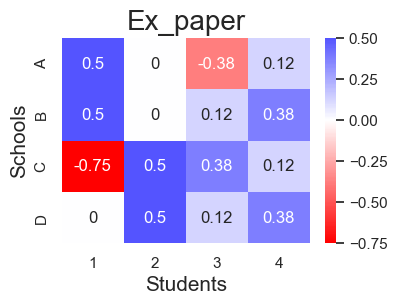

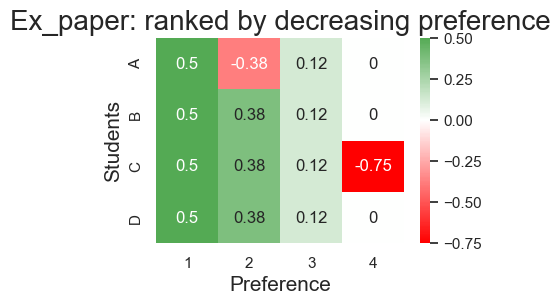

<Figure size 400x266.667 with 0 Axes>

In [47]:
p[0][2] = -3/8
p[2][0] = -3/4

A = Assignment(MyData, p, "Ex_paper")
A.visualize()

In [27]:
# Example of a simple MILP formulation in Gurobi 

from pulp import LpProblem, LpVariable, LpMaximize, GUROBI

# Define a simple problem
prob = LpProblem("SimpleProblem", LpMaximize)

# Define variables
x = LpVariable("x", lowBound=0)  # x >= 0
y = LpVariable("y", lowBound=0)  # y >= 0

# Objective Function
prob += 3 * x + 2 * y, "Objective"

# Constraints
prob += 2 * x + y <= 20, "Constraint 1"
prob += 4 * x + 3 * y <= 50, "Constraint 2"

# Solve using Gurobi API
prob.solve(GUROBI())

# Print the results
print(f"Status: {prob.status}")
print(f"x = {x.varValue}")
print(f"y = {y.varValue}")
prob.writeLP("Test.lp")


Set parameter Username
Set parameter LicenseID to value 2595965
Academic license - for non-commercial use only - expires 2025-12-05
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 2 columns and 4 nonzeros
Model fingerprint: 0x02dd6d3c
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [2e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 5e+01]
Presolve time: 0.01s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0000000e+30   3.250000e+30   5.000000e+00      0s
       2    3.5000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.500000000e+01
Gurobi status= 2

[x, y]